# Generate Low Temperature Reactions

The goal of this notebook is to allow you to generate all the species that would occur by systematically applying known low-temperature pathways to a starting fuel molecule.

You might do this to generate species that you then put into an RMG input file.

These are the pathways, from https://doi.org/10.1016/j.combustflame.2015.07.005
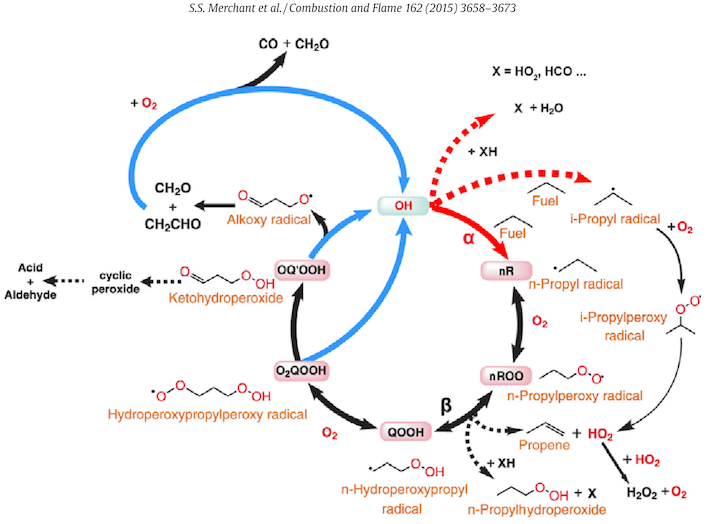

In [1]:
import sys, os
sys.path.insert(0,os.path.expandvars("$RMGpy"))

In [2]:
from rmgpy.rmg.main import RMG
from rmgpy.rmg.model import CoreEdgeReactionModel
from rmgpy import settings
from IPython.display import display
from arkane.output import prettify

Declare database variables here by changing the thermo and reaction libraries, or restrict to certain reaction families.  

In [3]:
database = """
database(
    thermoLibraries = ['BurkeH2O2','primaryThermoLibrary','DFT_QCI_thermo','CBS_QB3_1dHR','Narayanaswamy','Chernov'],
    reactionLibraries = [],
    seedMechanisms = [],
    kineticsDepositories = ['training'],
    kineticsFamilies = [
    'H_Abstraction',
    'R_Recombination',
    'R_Addition_MultipleBond',
    'intra_H_migration',
    'Intra_R_Add_Endocyclic',
    'Intra_R_Add_Exocyclic'
    ],
    kineticsEstimator = 'rate rules',
)

options(
    verboseComments=True,  # Set to True for detailed kinetics comments
)
"""

List all species you want reactions between

In [4]:
speciesList = """
species(
    label='c10',
    reactive=True,
    structure=SMILES("CCCCCCCCCC")
)

species(
    label='o2',
    reactive=True,
    structure=SMILES("[O][O]")
)
"""

In [5]:
# Write input file to disk
os.makedirs('temp',exist_ok=True)
inputFile = open('temp/input.py','w')
inputFile.write(database)
inputFile.write(speciesList)
inputFile.close()

In [6]:
# initialize RMG instance
from rmgpy.tools.generate_reactions import RMG
kwargs = {
            'restart': '',
            'walltime': '00:00:00:00',
            'kineticsdatastore': True
    }
rmg = RMG(input_file='temp/input.py', output_directory='temp')

rmg.initialize(**kwargs)


In [23]:
from rmgpy.molecule import Molecule

In [24]:
from collections import defaultdict
molecules = defaultdict(set)

def union(*args):
    out = set()
    for a in args:
        out.update(molecules[a])
    return out

In [25]:
molecules['fuel'].add(Molecule(smiles='CCCCCCCCCC'))
molecules['H'].add(Molecule(smiles='[H]'))
molecules

defaultdict(set,
            {'fuel': {Molecule(smiles="CCCCCCCCCC")},
             'H': {Molecule(smiles="[H]")}})

In [26]:
union('fuel','H')

{Molecule(smiles="[H]"), Molecule(smiles="CCCCCCCCCC")}

In [27]:
# React fuel with H to get the radicals R
reactions = rmg.database.kinetics.react_molecules(union('fuel', 'H'), only_families='H_Abstraction')
for r in reactions:
    for prod in r.products:
        if prod.get_formula() == 'H2':
            continue
        molecules['R'].add(prod)
molecules

defaultdict(set,
            {'fuel': {Molecule(smiles="CCCCCCCCCC")},
             'H': {Molecule(smiles="[H]")},
             'R': {Molecule(smiles="C[CH]CCCCCCCC"),
              Molecule(smiles="[CH2]CCCCCCCCC"),
              Molecule(smiles="CC[CH]CCCCCCC"),
              Molecule(smiles="CCC[CH]CCCCCC"),
              Molecule(smiles="CCCC[CH]CCCCC")}})

In [28]:
molecules['O2'].add(Molecule(smiles='[O][O]'))
molecules

defaultdict(set,
            {'fuel': {Molecule(smiles="CCCCCCCCCC")},
             'H': {Molecule(smiles="[H]")},
             'R': {Molecule(smiles="C[CH]CCCCCCCC"),
              Molecule(smiles="[CH2]CCCCCCCCC"),
              Molecule(smiles="CC[CH]CCCCCCC"),
              Molecule(smiles="CCC[CH]CCCCCC"),
              Molecule(smiles="CCCC[CH]CCCCC")},
             'O2': {Molecule(smiles="[O][O]")}})

In [29]:
# React R with O2 to get the ROO
o2 = list(molecules['O2'])[0]
for s in molecules['R']:
    reactions = rmg.database.kinetics.generate_reactions_from_families((s, o2), only_families='R_Recombination')
    display(s)
    for r in reactions:
        print(r)
        molecules['ROO'].add(r.products[0].molecule[0])
molecules

[O][O] + C[CH]CCCCCCCC <=> CCCCCCCCC(C)O[O]


[O][O] + [CH2]CCCCCCCCC <=> CCCCCCCCCCO[O]


[O][O] + CC[CH]CCCCCCC <=> CCCCCCCC(CC)O[O]


[O][O] + CCC[CH]CCCCCC <=> CCCCCCC(CCC)O[O]


[O][O] + CCCC[CH]CCCCC <=> CCCCCC(CCCC)O[O]


defaultdict(set,
            {'fuel': {Molecule(smiles="CCCCCCCCCC")},
             'H': {Molecule(smiles="[H]")},
             'R': {Molecule(smiles="C[CH]CCCCCCCC"),
              Molecule(smiles="[CH2]CCCCCCCCC"),
              Molecule(smiles="CC[CH]CCCCCCC"),
              Molecule(smiles="CCC[CH]CCCCCC"),
              Molecule(smiles="CCCC[CH]CCCCC")},
             'O2': {Molecule(smiles="[O][O]")},
             'ROO': {Molecule(smiles="CCCCCCCCCCO[O]"),
              Molecule(smiles="CCCCCCC(CCC)O[O]"),
              Molecule(smiles="CCCCCCCC(CC)O[O]"),
              Molecule(smiles="CCCCCC(CCCC)O[O]"),
              Molecule(smiles="CCCCCCCCC(C)O[O]")}})

CCCCCCCCCCO[O] <=> CCCCCCCCC[CH]OO
CCCCCCCCCCO[O] <=> CCCCCCCC[CH]COO
CCCCCCCCCCO[O] <=> CCCCCCC[CH]CCOO
CCCCCCCCCCO[O] <=> CCCCCC[CH]CCCOO
CCCCCCCCCCO[O] <=> CCCCC[CH]CCCCOO
CCCCCCCCCCO[O] <=> CCCC[CH]CCCCCOO


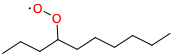

CCCCCCC(CCC)O[O] <=> CCCCCC[C](CCC)OO
CCCCCCC(CCC)O[O] <=> CCCCC[CH]C(CCC)OO
CCCCCCC(CCC)O[O] <=> CC[CH]C(CCCCCC)OO
CCCCCCC(CCC)O[O] <=> CCCC[CH]CC(CCC)OO
CCCCCCC(CCC)O[O] <=> C[CH]CC(CCCCCC)OO
CCCCCCC(CCC)O[O] <=> CCC[CH]CCC(CCC)OO
CCCCCCC(CCC)O[O] <=> [CH2]CCC(CCCCCC)OO
CCCCCCC(CCC)O[O] <=> CC[CH]CCCC(CCC)OO
CCCCCCC(CCC)O[O] <=> C[CH]CCCCC(CCC)OO


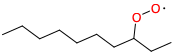

CCCCCCCC(CC)O[O] <=> CCCCCCC[C](CC)OO
CCCCCCCC(CC)O[O] <=> CCCCCC[CH]C(CC)OO
CCCCCCCC(CC)O[O] <=> C[CH]C(CCCCCCC)OO
CCCCCCCC(CC)O[O] <=> CCCCC[CH]CC(CC)OO
CCCCCCCC(CC)O[O] <=> [CH2]CC(CCCCCCC)OO
CCCCCCCC(CC)O[O] <=> CCCC[CH]CCC(CC)OO
CCCCCCCC(CC)O[O] <=> CCC[CH]CCCC(CC)OO
CCCCCCCC(CC)O[O] <=> CC[CH]CCCCC(CC)OO


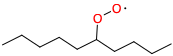

CCCCCC(CCCC)O[O] <=> CCCCC[C](CCCC)OO
CCCCCC(CCCC)O[O] <=> CCCC[CH]C(CCCC)OO
CCCCCC(CCCC)O[O] <=> CCC[CH]C(CCCCC)OO
CCCCCC(CCCC)O[O] <=> CCC[CH]CC(CCCC)OO
CCCCCC(CCCC)O[O] <=> CC[CH]CC(CCCCC)OO
CCCCCC(CCCC)O[O] <=> CC[CH]CCC(CCCC)OO
CCCCCC(CCCC)O[O] <=> C[CH]CCC(CCCCC)OO
CCCCCC(CCCC)O[O] <=> C[CH]CCCC(CCCC)OO
CCCCCC(CCCC)O[O] <=> [CH2]CCCC(CCCCC)OO
CCCCCC(CCCC)O[O] <=> [CH2]CCCCC(CCCC)OO


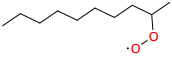

CCCCCCCCC(C)O[O] <=> CCCCCCCC[C](C)OO
CCCCCCCCC(C)O[O] <=> CCCCCCC[CH]C(C)OO
CCCCCCCCC(C)O[O] <=> [CH2]C(CCCCCCCC)OO
CCCCCCCCC(C)O[O] <=> CCCCCC[CH]CC(C)OO
CCCCCCCCC(C)O[O] <=> CCCCC[CH]CCC(C)OO
CCCCCCCCC(C)O[O] <=> CCCC[CH]CCCC(C)OO
CCCCCCCCC(C)O[O] <=> CCC[CH]CCCCC(C)OO


defaultdict(set,
            {'fuel': {Molecule(smiles="CCCCCCCCCC")},
             'H': {Molecule(smiles="[H]")},
             'R': {Molecule(smiles="C[CH]CCCCCCCC"),
              Molecule(smiles="[CH2]CCCCCCCCC"),
              Molecule(smiles="CC[CH]CCCCCCC"),
              Molecule(smiles="CCC[CH]CCCCCC"),
              Molecule(smiles="CCCC[CH]CCCCC")},
             'O2': {Molecule(smiles="[O][O]")},
             'ROO': {Molecule(smiles="CCCCCCCCCCO[O]"),
              Molecule(smiles="CCCCCCC(CCC)O[O]"),
              Molecule(smiles="CCCCCCCC(CC)O[O]"),
              Molecule(smiles="CCCCCC(CCCC)O[O]"),
              Molecule(smiles="CCCCCCCCC(C)O[O]")},
             'QOOH': {Molecule(smiles="CCCC[CH]CCC(CC)OO"),
              Molecule(smiles="CCC[CH]CCCC(CC)OO"),
              Molecule(smiles="CC[CH]CCCCC(CC)OO"),
              Molecule(smiles="CCCCC[C](CCCC)OO"),
              Molecule(smiles="CCCC[CH]C(CCCC)OO"),
              Molecule(smiles="CCC[CH]C(CCCCC)OO"),
          

In [30]:
# Isomerize ROO to get QOOH
for s in molecules['ROO']:
    reactions = rmg.database.kinetics.generate_reactions_from_families((s, ), only_families='intra_H_migration')
    display(s)
    for r in reactions:
        print(r)
        molecules['QOOH'].add(r.products[0].molecule[0])
molecules

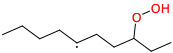

[O][O] + CCCC[CH]CCC(CC)OO <=> CCCCC(CCC(CC)OO)O[O]


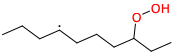

[O][O] + CCC[CH]CCCC(CC)OO <=> CCCC(CCCC(CC)OO)O[O]


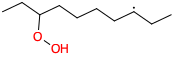

[O][O] + CC[CH]CCCCC(CC)OO <=> CCC(CCCCC(CC)OO)O[O]


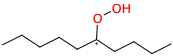

[O][O] + CCCCC[C](CCCC)OO <=> CCCCCC(CCCC)(O[O])OO


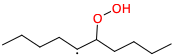

[O][O] + CCCC[CH]C(CCCC)OO <=> CCCCC(O[O])C(CCCC)OO


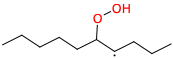

[O][O] + CCC[CH]C(CCCCC)OO <=> CCCCCC(OO)C(CCC)O[O]


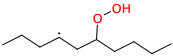

[O][O] + CCC[CH]CC(CCCC)OO <=> CCCCC(CC(CCC)O[O])OO


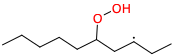

[O][O] + CC[CH]CC(CCCCC)OO <=> CCCCCC(CC(CC)O[O])OO


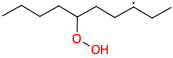

[O][O] + CC[CH]CCC(CCCC)OO <=> CCCCC(CCC(CC)O[O])OO


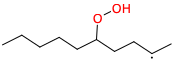

[O][O] + C[CH]CCC(CCCCC)OO <=> CCCCCC(CCC(C)O[O])OO


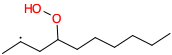

[O][O] + C[CH]CC(CCCCCC)OO <=> CCCCCCC(CC(C)O[O])OO


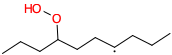

[O][O] + CCC[CH]CCC(CCC)OO <=> CCCC(CCC(CCC)OO)O[O]


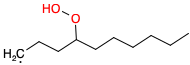

[O][O] + [CH2]CCC(CCCCCC)OO <=> CCCCCCC(CCCO[O])OO


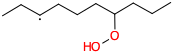

[O][O] + CC[CH]CCCC(CCC)OO <=> CCCC(CCCC(CC)O[O])OO


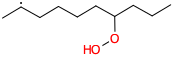

[O][O] + C[CH]CCCCC(CCC)OO <=> CCCC(CCCCC(C)O[O])OO


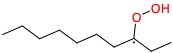

[O][O] + CCCCCCC[C](CC)OO <=> CCCCCCCC(CC)(O[O])OO


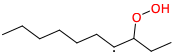

[O][O] + CCCCCC[CH]C(CC)OO <=> CCCCCCC(O[O])C(CC)OO


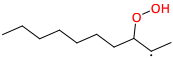

[O][O] + C[CH]C(CCCCCCC)OO <=> CCCCCCCC(OO)C(C)O[O]


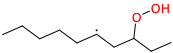

[O][O] + CCCCC[CH]CC(CC)OO <=> CCCCCC(CC(CC)OO)O[O]


[O][O] + CCCCCCCC[CH]COO <=> CCCCCCCCC(COO)O[O]


[O][O] + CCCCCC[CH]CCCOO <=> CCCCCCC(CCCOO)O[O]


[O][O] + CCCCCCC[CH]CCOO <=> CCCCCCCC(CCOO)O[O]


[O][O] + CCCCC[CH]CCCCOO <=> CCCCCC(CCCCOO)O[O]


[O][O] + CCCC[CH]CCCCCOO <=> CCCCC(CCCCCOO)O[O]


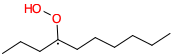

[O][O] + CCCCCC[C](CCC)OO <=> CCCCCCC(CCC)(O[O])OO


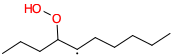

[O][O] + CCCCC[CH]C(CCC)OO <=> CCCCCC(O[O])C(CCC)OO


[O][O] + CCCCCCCCC[CH]OO <=> CCCCCCCCCC(O[O])OO


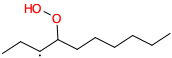

[O][O] + CC[CH]C(CCCCCC)OO <=> CCCCCCC(OO)C(CC)O[O]


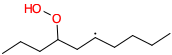

[O][O] + CCCC[CH]CC(CCC)OO <=> CCCCC(CC(CCC)OO)O[O]


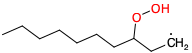

[O][O] + [CH2]CC(CCCCCCC)OO <=> CCCCCCCC(CCO[O])OO


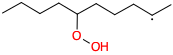

[O][O] + C[CH]CCCC(CCCC)OO <=> CCCCC(CCCC(C)O[O])OO


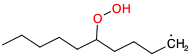

[O][O] + [CH2]CCCC(CCCCC)OO <=> CCCCCC(CCCCO[O])OO


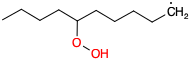

[O][O] + [CH2]CCCCC(CCCC)OO <=> CCCCC(CCCCCO[O])OO


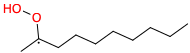

[O][O] + CCCCCCCC[C](C)OO <=> CCCCCCCCC(C)(O[O])OO


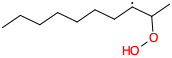

[O][O] + CCCCCCC[CH]C(C)OO <=> CCCCCCCC(O[O])C(C)OO


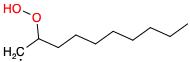

[O][O] + [CH2]C(CCCCCCCC)OO <=> CCCCCCCCC(CO[O])OO


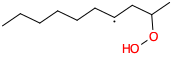

[O][O] + CCCCCC[CH]CC(C)OO <=> CCCCCCC(CC(C)OO)O[O]


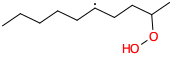

[O][O] + CCCCC[CH]CCC(C)OO <=> CCCCCC(CCC(C)OO)O[O]


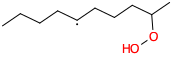

[O][O] + CCCC[CH]CCCC(C)OO <=> CCCCC(CCCC(C)OO)O[O]


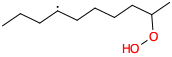

[O][O] + CCC[CH]CCCCC(C)OO <=> CCCC(CCCCC(C)OO)O[O]


defaultdict(set,
            {'fuel': {Molecule(smiles="CCCCCCCCCC")},
             'H': {Molecule(smiles="[H]")},
             'R': {Molecule(smiles="C[CH]CCCCCCCC"),
              Molecule(smiles="[CH2]CCCCCCCCC"),
              Molecule(smiles="CC[CH]CCCCCCC"),
              Molecule(smiles="CCC[CH]CCCCCC"),
              Molecule(smiles="CCCC[CH]CCCCC")},
             'O2': {Molecule(smiles="[O][O]")},
             'ROO': {Molecule(smiles="CCCCCCCCCCO[O]"),
              Molecule(smiles="CCCCCCC(CCC)O[O]"),
              Molecule(smiles="CCCCCCCC(CC)O[O]"),
              Molecule(smiles="CCCCCC(CCCC)O[O]"),
              Molecule(smiles="CCCCCCCCC(C)O[O]")},
             'QOOH': {Molecule(smiles="CCCC[CH]CCC(CC)OO"),
              Molecule(smiles="CCC[CH]CCCC(CC)OO"),
              Molecule(smiles="CC[CH]CCCCC(CC)OO"),
              Molecule(smiles="CCCCC[C](CCCC)OO"),
              Molecule(smiles="CCCC[CH]C(CCCC)OO"),
              Molecule(smiles="CCC[CH]C(CCCCC)OO"),
          

In [31]:
# React QOOH with O2 to get the O2QOOH
o2 = list(molecules['O2'])[0]
for s in molecules['QOOH']:
    reactions = rmg.database.kinetics.generate_reactions_from_families((s, o2), only_families='R_Recombination')
    display(s)
    for r in reactions:
        print(r)
        molecules['O2QOOH'].add(r.products[0].molecule[0])
molecules

These are the OOQOOH


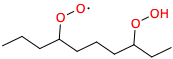

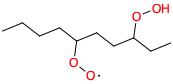

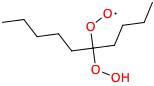

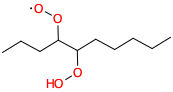

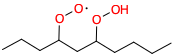

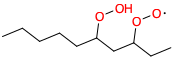

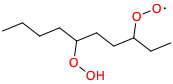

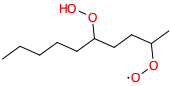

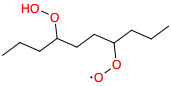

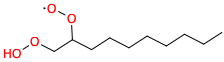

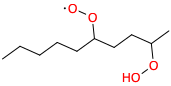

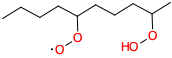

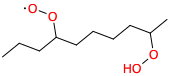

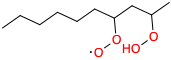

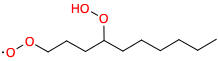

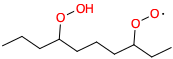

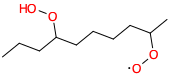

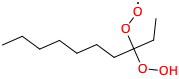

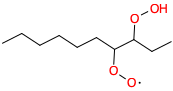

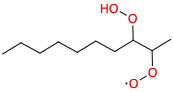

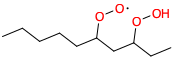

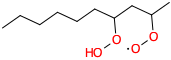

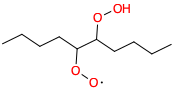

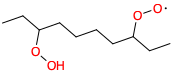

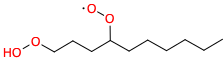

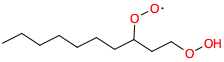

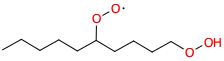

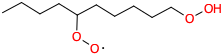

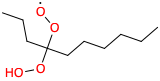

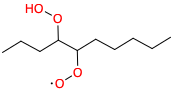

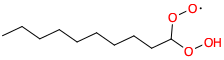

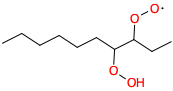

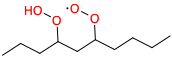

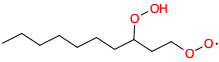

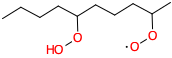

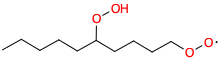

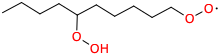

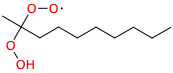

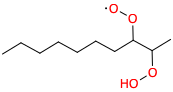

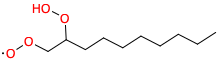

In [32]:
print("These are the OOQOOH")
for m in molecules['O2QOOH']:
    display(m)

In [33]:
# What next? OH + keto-hydroperoxide   or   HO2 + alkenyl hydroperoxide 